In [1]:
import os
import cv2
import torch
import numpy as np
import random
import timm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from facenet_pytorch import MTCNN
from torchvision import transforms
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Definir SEED para garantir reprodutibilidade
SEED = 42

# Fixar seed para bibliotecas relevantes
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Garantir que operações com cudnn sejam determinísticas
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Definir dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Carregar modelo XceptionNet pré-treinado para detecção de deepfakes
class DeepfakeDetector(torch.nn.Module):
    def __init__(self):
        super(DeepfakeDetector, self).__init__()
        self.model = timm.create_model("xception", pretrained=True, num_classes=2)

    def forward(self, x):
        return self.model(x)

In [5]:
# Inicializar modelo e definir dispositivo
model = DeepfakeDetector().to(device)
model.eval()

/home/flavio/anaconda3/envs/myenv/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


DeepfakeDetector(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(in

In [6]:
# Transformações para normalização
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # tamanho adequado para XceptionNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
# Função para extrair frames do vídeo
def extract_frames(video_path, interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % interval == 0:
            frames.append(frame)
        frame_count += 1

    cap.release()
    return frames

In [8]:
# Função para detectar rostos nos frames usando MTCNN
def detect_faces(frames):
    mtcnn = MTCNN(keep_all=True, device=device)
    faces = []
    for i, frame in enumerate(frames):
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        boxes, _ = mtcnn.detect(image)

        if boxes is not None:
            for j, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                face = image.crop((x1, y1, x2, y2))
                
                # Adicionar à lista de resultados
                faces.append((frame, face))

    return faces

In [9]:
# Função para classificar rostos como real ou falso
def classify_faces(faces):
    real_count = 0
    fake_count = 0

    for frame, face in faces:
        face = transform(face).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(face)
            prob = torch.softmax(output, dim=1)[0]
            label = "Fake" if prob[1] > prob[0] else "Real"
            
            if label == "Fake":
                fake_count += 1
            else:
                real_count += 1

    return "Fake" if fake_count > real_count else "Real"

In [10]:
# Função para processar vídeos no diretório e gerar matriz de confusão
def evaluate_videos(video_dir):
    true_labels = []
    pred_labels = []

    for class_label in ["Real", "Fake"]:
        class_dir = os.path.join(video_dir, class_label)

        if not os.path.exists(class_dir):
            continue

        # Listar apenas os primeiros 10 arquivos de cada categoria (Real e Fake)
        video_files = sorted([f for f in os.listdir(class_dir) if f.endswith(".mp4")])[:10]

        #for video_file in os.listdir(class_dir):
        for video_file in video_files:
            if video_file.endswith(".mp4"):
                video_path = os.path.join(class_dir, video_file)
                print(f"\nProcessando: {video_file} ({class_label})")

                # Extração de frames e detecção de deepfake
                frames = extract_frames(video_path)
                faces = detect_faces(frames)

                if not faces:
                    print(f"Aviso: Nenhum rosto detectado no vídeo {video_file}. Classificação padrão como 'Real'.")
                    pred_label = "Real"
                else:
                    pred_label = classify_faces(faces)

                # Salvar rótulos reais e preditos
                true_labels.append(class_label)
                pred_labels.append(pred_label)

    # Gerar matriz de confusão
    cm = confusion_matrix(true_labels, pred_labels, labels=["Real", "Fake"])
    df_cm = pd.DataFrame(cm, index=["Real", "Fake"], columns=["Predito Real", "Predito Fake"])

    # Exibir matriz de confusão
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão - Detecção de Deepfake")
    plt.show()

    # Exibir relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(true_labels, pred_labels, target_names=["Real", "Fake"]))


Processando: id0_0000.mp4 (Real)

Processando: id0_0001.mp4 (Real)

Processando: id0_0002.mp4 (Real)

Processando: id0_0003.mp4 (Real)

Processando: id0_0004.mp4 (Real)

Processando: id0_0005.mp4 (Real)

Processando: id0_0006.mp4 (Real)

Processando: id0_0007.mp4 (Real)

Processando: id0_0008.mp4 (Real)

Processando: id0_0009.mp4 (Real)

Processando: id0_id1_0000.mp4 (Fake)

Processando: id0_id1_0001.mp4 (Fake)

Processando: id0_id1_0002.mp4 (Fake)

Processando: id0_id1_0003.mp4 (Fake)

Processando: id0_id1_0005.mp4 (Fake)

Processando: id0_id1_0006.mp4 (Fake)

Processando: id0_id1_0007.mp4 (Fake)

Processando: id0_id1_0009.mp4 (Fake)

Processando: id0_id2_0000.mp4 (Fake)

Processando: id0_id2_0001.mp4 (Fake)


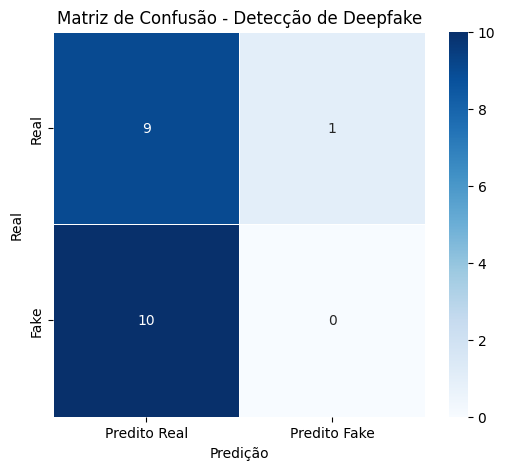


Relatório de Classificação:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00        10
        Fake       0.47      0.90      0.62        10

    accuracy                           0.45        20
   macro avg       0.24      0.45      0.31        20
weighted avg       0.24      0.45      0.31        20



In [11]:
# Diretório de vídeos de teste
video_test_dir = "videos-teste/CELEB-DF"

# Avaliação de todos os vídeos no diretório
evaluate_videos(video_test_dir)